## Sequence models

- when working with language we want to estimate the joint probability of an entire sequence
- common task when working with sequences composed of discrete tokens is to estimate probabilities of sequences. 
- Language models prove useful for all sorts of reasons. 
- Sometimes we want to evaluate the likelihood of sentences. For example, we might wish to compare the naturalness of two candidate outputs generated by a machine translation system or by a speech recognition system. 
- But language modeling gives us not only the capacity to evaluate likelihood, but the ability to generate sequences, and even to optimize for the most likely sequences.
- Recall that we can write a joint distribution as a chain of conditional distributions:
$$
p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_T) = p(\boldsymbol{\mathsf x}_1) \prod_{t = 2}^{T} p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1}).
$$
- for discrete signals the output of a model must be a probability distribution $p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1})$. 
- Markov condition: the future is conditionally independent of the past, given the recent history
- We often find it useful to work with models that proceed as though a Markov condition were satisfied, even when we know that this is only approximately true. With real text documents we continue to gain information as we include more and more leftwards context. But these gains diminish rapidly. Thus, sometimes we compromise, obviating computational and statistical difficulties by training models whose validity depends on a 
kth-order Markov condition.

In [1]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

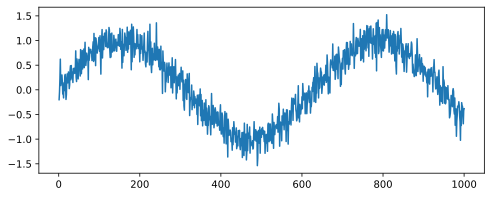

In [2]:
import torch

batch_size=16
T=1000
num_train=600
tau=4
t = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * t) + torch.randn(T) * 0.2
plt.figure(figsize=(8, 3))
plt.plot(t, x);

Our task is to model $[\boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t - 1}] \mapsto \boldsymbol{\mathsf{x}}_{t}$

In [3]:
# stack offsets each with length T - tau
f = torch.stack([x[i: T-tau+i] for i in range(tau)], 1)
print(f.shape)
f

torch.Size([996, 4])


tensor([[-0.2003, -0.0386,  0.2260,  0.6210],
        [-0.0386,  0.2260,  0.6210,  0.0866],
        [ 0.2260,  0.6210,  0.0866,  0.1665],
        ...,
        [-0.2604, -0.3177, -0.3375, -0.5154],
        [-0.3177, -0.3375, -0.5154, -0.6876],
        [-0.3375, -0.5154, -0.6876, -0.4226]])

In [4]:
y = x[tau: ].reshape(-1, 1)
y[0]

tensor([0.0866])

Creating the data loader:

In [5]:
from torch.utils.data import TensorDataset, DataLoader

data = TensorDataset(f, y)
input, tgt = next(iter(data))
input, tgt

(tensor([-0.2003, -0.0386,  0.2260,  0.6210]), tensor([0.0866]))

In [6]:
import torch.nn as nn

model = nn.Sequential(nn.Linear(4, 1))
optim = torch.optim.SGD(model.parameters(), lr=0.01)
for e in range(3):
    for input, tgt in DataLoader(data, batch_size=16, shuffle=True):
        loss = ((model(input) - tgt) ** 2).mean()
        loss.backward()
        optim.step()
        optim.zero_grad()

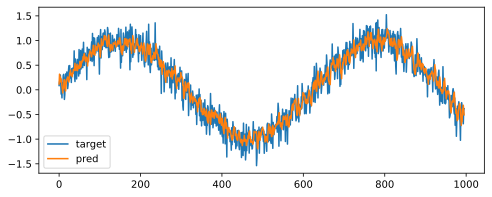

In [7]:
plt.figure(figsize=(8, 3))
plt.plot(y, label="target")
plt.plot(model(f).reshape(-1).tolist(), label="pred")
plt.legend();

look ahead predictions. suppose we have measurement data up to $t = 604$ and we want to predict $t = 605, \ldots, 609$. To do this we can reuse predictions. Beginning precisely $t = 609$, we use solely predicted values instead of observed data:

$$
\begin{aligned}
& \hat{x}_{605}=f\left(x_{601}, x_{602}, x_{603}, x_{604}\right) \\
& \hat{x}_{606}=f\left(x_{602}, x_{603}, x_{604}, \hat{x}_{605}\right) \\
& \hat{x}_{607}=f\left(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}\right) \\
& \hat{x}_{608}=f\left(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}\right) \\
& \hat{x}_{609}=f\left(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}\right)
\end{aligned}
$$

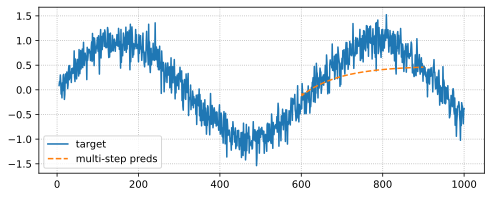

In [8]:
t0 = 601
preds = []
k_max = 300
ctx = x[t0: t0 + tau].tolist()
for i in range(k_max):
    x_hat = model(torch.tensor(ctx).reshape(1, -1))[0]
    preds.append(x_hat.item())
    ctx = ctx[1:] + [x_hat]


plt.figure(figsize=(8, 3))
plt.plot(t[tau:], y, label="target")
plt.plot(range(t0, t0 + k_max), preds, label="multi-step preds", linestyle="dashed")
plt.grid(linestyle="dotted")
plt.legend();

## Raw test to sequence data

In [9]:
import collections
import random
import re
import torch

we will work with H. G. Wells’ [The Time Machine](http://www.gutenberg.org/ebooks/35), a book containing just over 30,000 words. While real applications will typically involve significantly larger datasets, this is sufficient to demonstrate the preprocessing pipeline. 

In [10]:
!rm chapter.py; touch chapter.py

In [11]:
!mkdir ./data
!curl "https://www.gutenberg.org/cache/epub/35/pg35.txt" --output ./data/time_machine.txt

mkdir: ./data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199k  100  199k    0     0   103k      0  0:00:01  0:00:01 --:--:--  103k


This has some prefix by Project Gutenberg that we have to remove:

In [12]:
text = open("./data/time_machine.txt").read()
text[:300]

'\ufeffThe Project Gutenberg eBook of The Time Machine\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License'

In [13]:
start = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
end = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
text = text[text.find(start) + len(start): text.find(end)]
text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
print(text[:100])
print(text[-100:])

the time machine an invention by h g wells contents i introduction ii the machine iii the time trave
when mind and strength had gone gratitude and a mutual tenderness still lived on in the heart of man


### Tokenization

Tokens are the atomic units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice. For example, we could represent the sentence “Baby needs a new pair of shoes” as a sequence of 7 words, where the set of all words comprise a large vocabulary (typically tens or hundreds of thousands of words). Or we would represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (there are only 256 distinct ASCII characters). Below, we tokenize our preprocessed text into a sequence of characters.



In [14]:
tokens = list(text)
", ".join(tokens[:42])  # https://en.wikipedia.org/wiki/File:Answer_to_Life_42.svg

't, h, e,  , t, i, m, e,  , m, a, c, h, i, n, e,  , a, n,  , i, n, v, e, n, t, i, o, n,  , b, y,  , h,  , g,  , w, e, l, l, s'

### Vocabulary

can think of vocab as dictionary that maps `token` $\mapsto$ `index`
and also offers utils such as an inversion map

In [15]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.itot = ["<unk>"] + list(sorted(set(
            reserved_tokens +   # i.e. reserved = not subject to min_freq
            [token for token, freq in self.token_freqs if freq >= min_freq]
        )))
        self.ttoi = {tok: idx for idx, tok in enumerate(self.itot)}

    def __len__(self):
        return len(self.itot)
    
    def __getitem__(self, tokens):
        if isinstance(tokens, (list, tuple)):
            return [self.__getitem__(tok) for tok in tokens]
        else:
            return self.ttoi.get(tokens, self.unk)
            
    def to_tokens(self, indices):
        if hasattr(indices, "__len__"):
            return [self.itot[int(index)] for index in indices]
        else:
            return self.itot[indices]

    @property
    def unk(self) -> int:
        return self.ttoi["<unk>"]

Recall that `tokens` is `list(text)`.

In [16]:
vocab = Vocab(tokens=tokens) 
corpus = vocab[tokens]

assert len(set(corpus)) + 1 == len(vocab)
print(len(vocab))
print(vocab.token_freqs[:3], "...", vocab.token_freqs[-3:])
print(len(corpus))
print(vocab.to_tokens(corpus[:16]))

28
[(' ', 32894), ('e', 17918), ('t', 13591)] ... [('z', 106), ('j', 97), ('q', 95)]
174215
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e']


In [17]:
import os
import requests

class TimeMachine:
    def __init__(self, download=False):
        self.filepath = "./data/time_machine.txt"
        if download or not os.path.exists(self.filepath):
            self._download()
        
    def _download(self):
        url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(self.filepath, "wb") as output:
            output.write(response.content)
        
    def _preprocess(self, text: str):
        s = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        e = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    def _tokenize(self, text: str):
        return list(text)

    def build(self, vocab=None):
        with open(self.filepath, "r") as f:
            text = f.read()
        
        text = self._preprocess(text)
        self.text = text
        self.tokens = self._tokenize(text)
        if vocab is None: 
            vocab = Vocab(self.tokens)

        corpus = vocab[tokens]
        return corpus, vocab

In [18]:
tm = TimeMachine(download=True)
corpus, vocab = tm.build()

In [19]:
print(tm.text[:100])
print(tm.text[-100:])
len(corpus), len(vocab)

the time machine an invention by h g wells contents i introduction ii the machine iii the time trave
when mind and strength had gone gratitude and a mutual tenderness still lived on in the heart of man


(174215, 28)

In [20]:
tm.text

'the time machine an invention by h g wells contents i introduction ii the machine iii the time traveller returns iv time travelling v in the golden age vi the sunset of mankind vii a sudden shock viii explanation ix the morlocks x when night came xi the palace of green porcelain xii in the darkness xiii the trap of the white sphinx xiv the further vision xv the time traveller s return xvi after the story epilogue i introduction the time traveller for so it will be convenient to speak of him was expounding a recondite matter to us his pale grey eyes shone and twinkled and his usually pale face was flushed and animated the fire burnt brightly and the soft radiance of the incandescent lights in the lilies of silver caught the bubbles that flashed and passed in our glasses our chairs being his patents embraced and caressed us rather than submitted to be sat upon and there was that luxurious after dinner atmosphere when thought runs gracefully free of the trammels of precision and he put i

Trying out the `<unk>` token for unknown characters:

In [21]:
vocab.to_tokens(vocab[list("$w@gger")])

['<unk>', 'w', '<unk>', 'g', 'g', 'e', 'r']

## Appendix: Zipf's law

After a few words that are considered exceptions, the frequency $f_i$ of the $i$-th most frequent word decays as follows:

$f_i \propto i^{-\alpha}$

which is equivalent to

$\log f_i = -\alpha \log i + c$

where $\alpha$ characterizes the token distribution and $c$ is a constant for the proportionality.

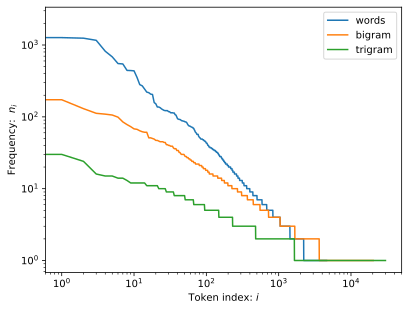

In [22]:
words = text.split()
word_freqs = Vocab(words).token_freqs
bigram_freqs = Vocab(["__".join(pair) for pair in zip(words[:-1], words[1:])]).token_freqs
trigram_freqs = Vocab(["__".join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]).token_freqs

plt.plot([freq for _, freq in word_freqs], label="words")
plt.plot([freq for _, freq in bigram_freqs], label="bigram")
plt.plot([freq for _, freq in trigram_freqs], label="trigram")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Frequency:  $n_i$")
plt.xlabel("Token index: $i$")
plt.legend();

**Remark.** Similar behavior (indeed a similar $\alpha$) has been observed for other English stories (e.g. [*Alice's Adventures in Wonderland*](https://www.gutenberg.org/cache/epub/11/pg11.txt)).

## Language models

Assume that a piece of text $s$ has been converted to a sequence of tokens $\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T.$  The goal of language models is to estimate the joint probability of the whole sequence:

$$
p(\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T).
$$

Language models are incredibly useful. For instance, an ideal language model should generate natural text on its own, simply by drawing one token at a time $\boldsymbol{\mathsf{x}}_t \sim p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1})$.

- instead of gibberish, it would be sufficient for generating a meaningful dialog, simply by conditioning the text on previous dialog fragments
- we are still very far from designing such a system, since it would need to *understand* the text rather than just generate grammatically sensible content (e.g. in terms of likelihood).
- Nonetheless, language models are of great service even in their limited form. 
- For instance, the phrases “to recognize speech” and “to wreck a nice beach” sound very similar. This can cause ambiguity in speech recognition, which is easily resolved through a language model that rejects the second translation as outlandish (i.e. low probability of occuring).

$$
p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_T) = p(\boldsymbol{\mathsf x}_1) \prod_{t = 2}^{T} p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1}).
$$

$$
\begin{aligned}
&p(\text{deep}, \text{learning}, \text{is}, \text{fun}) \\
= &p(\text{deep}) \cdot p(\text{learning} \mid \text{deep}) \cdot p(\text{is} \mid \text{deep}, \text{learning}) \cdot p(\text{fun} \mid \text{deep}, \text{learning}, \text{is}).
\end{aligned}
$$

- **Remark.** The probabilities can be estimated by [relative frequencies](https://en.wikipedia.org/wiki/Empirical_probability) perhaps with [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing), e.g. $p(\text{deep} \mid \text{learning}) \approx n(\text{deep}, \text{learning}) / n(\text{learning})$ . Moreover, we can truncate the context to at most $\tau$ many terms as a Markov hypothesis.

## Perplexity

- how to measure the quality of the language model, which we will then use to evaluate our models in the subsequent sections. 
- One way is to check how *surprising* the text is.
- A good language model is able to predict, with high accuracy, the tokens that come next.
- Consider the following continuations of the phrase "It is raining", as proposed by different language models:
    ```
    “It is raining outside”
    “It is raining banana tree”
    “It is raining piouw;kcj pwepoiut”
    ```

- Example 1 is clearly the best, although not necessarily factual or accurate, model predicts kind of word correctly.
- example 2 is nonsensical, but at least model has learned some degree of correlation between words (banan & tree)
- example 3 indicates poor training

To evaluate a language model, we can use the cross-entropy on the next token which is equivalent to maximizing the likelihood of a text. We normalize this over the number of tokens predicted:

$$
\mathcal{L} = \frac{1}{n}\sum_{t=1}^n - \log p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t-1})
$$

Here we condition on a fixed number of tokens $\tau$ which means we sample a fixed number of tokens at each step (e.g. a moving window). For a classifier that predicts all tokens uniformly random, then $\mathcal{L} = \log |\mathcal{V}|$ where $\mathcal{V}$ is the set of tokens. This is a useful baseline. A similarly simple model predicts based on prior probabilities for each token based on count in the training data.

Historically, researchers in NLP also use *perplexity* (PP) which is simply the exponential of the above expression:

$$
\exp\left(\frac{1}{n}\sum_{t=1}^n - \log p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t-1})\right).
$$

Note that perplexity is equivalent to an inverse likelihood: 

$$
\text{PP} = \frac{1}{\sqrt[n]{\prod_{t=1}^n p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t-1})}} = \sqrt[n]{\prod_{t=1}^n \frac{1}{p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t - \tau:t-1})}}.
$$

Hence, for a perfect model, $\text{PP} = 1.$ On the other hand, if the model predicts $p \approx 0$ for the correct token at each step, then we get $\text{PP} = \infty.$ As a baseline, for a uniformly random model, we have $\text{PP} = |\mathcal{V}|.$ This provides a nontrivial upper bound that any useful model must beat. So, we have $\text{PP}$ values $\infty > |\mathcal{V}| \geq 1$ for the three regimes. This can be interpreted as the average number of tries to get the correct prediction at each step, e.g. single try for perfect model.

**Remark.** For the usual cross entropy, this corresponds to $\infty > \log |\mathcal{V}| \geq 0.$

## Recurrent Neural Networks (RNN)

In the previous chapter we described a Markov model using $n$-grams where the conditional probability of token $\boldsymbol{\mathsf{x}}_t$ depends only on the last $n-1$ tokens. If we want to incorporate the possible effect of tokens earlier than $n-1$ time steps, we need to increase $n$. But as we saw the number of model parameters would also increase exponentially with it as we need to store $|\mathcal{V}|^n$ numbers for a vocabulary set $\mathcal{V}.$ Furthermore, by Zipf's law, data becomes more sparse as $n$ increases, so the model does not necessarily improve with larger $n.$

Rather than modeling the next token directly in terms of previous tokens, we can instead use a latent variable that, in principle, stores *all* previous information up to the previous time step:

$$
p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1}) \approx p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf h}_{t-1})
$$

where $\boldsymbol{\mathsf h}_{t-1}$ is a *hidden state* that stores information up to the time step $t - 1.$ The hidden state is updated based on the current input and the previous state: 

$$
\boldsymbol{\mathsf h}_{t} = f(\boldsymbol{\mathsf x}_{t}, \boldsymbol{\mathsf h}_{t-1}),
$$

so that $\boldsymbol{\mathsf h}_{t} = F(\boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t}, \boldsymbol{\mathsf h}_{0})$ for some $\boldsymbol{\mathsf h}_{0}$ where $F$ involves recursively applying $f.$ Note that for a sufficiently powerful function $f$, the latent variable model above is not an approximation, since $\boldsymbol{\mathsf h}_{t}$ can simply store all $\boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t}$ it has observed so far. 

### Simple RNN

RNNs use the same parameters at each time step, i.e. it is assumed that the dynamics is stationary. Practically, this means that the number of parameters does not grow as the sequence length increases.
The following implementation is called **Simple RNN**, the state update is calculated using essentially a linear layer where the embedding and hidden state are concatenated as input. Let tokens correspond to embedding vectors $\boldsymbol{\mathsf{x}}_t \in \mathbb{R}^d$, then

$$
\begin{aligned}
\boldsymbol{\mathsf{h}}_t &= \varphi(\boldsymbol{\mathsf{x}}_t \boldsymbol{\mathsf{U}} + \boldsymbol{\mathsf{h}}_{t-1} \boldsymbol{\mathsf{W}} + \boldsymbol{\mathsf{b}}) \\
\boldsymbol{\mathsf{y}}_t &= \boldsymbol{\mathsf{h}}_t \boldsymbol{\mathsf{V}} + \boldsymbol{\mathsf{c}}
\end{aligned}
$$

where $\boldsymbol{\mathsf{U}} \in \mathbb{R}^{d \times h}$, $\boldsymbol{\mathsf{W}} \in \mathbb{R}^{h \times h}$, and $\boldsymbol{\mathsf{b}} \in \mathbb{R}^{h}.$ Here $h$ is the dimensionality of the hidden state. For the outputs, we also have $\boldsymbol{\mathsf{V}} \in \mathbb{R}^{h \times q}$ and $\boldsymbol{\mathsf{c}} \in \mathbb{R}^{q}$ where $q$ is the dimensionality of the output. This computation can be seen in {numref}`04-simple-rnn`.

Note that $\boldsymbol{\mathsf{x}}_t$ can be one-hot vectors since the matrix $\boldsymbol{\mathsf{U}}$ can act as the embedding matrix for the tokens. In this case, $\boldsymbol{\mathsf{U}}$ has shape $(|\mathcal{V}|, h).$

<br>

```{figure} ../../../img/nn/04-simple-rnn.svg
---
width: 600px
name: 04-simple-rnn
align: center
---
Computational graph of an unrolled simple RNN. [Source](https://www.d2l.ai/chapter_recurrent-neural-networks/rnn.html)
```

First, we implement the recurrent layer. To implement batch computation, an input has shape $(B, T, d).$ That is, a batch of $B$ sequences of length $T$, consisting of vectors in $\mathbb{R}^d.$ Elements of a batch are computed in independently, ideally in parallel. At each step, the layer returns the state vector of shape $(B, h).$ This is stacked to get a tensor of shape $(B, T, h)$ consistent with the input.

In [23]:
import numpy as np
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, dim_inputs, dim_hidden):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.dim_inputs = dim_inputs
        self.W = nn.Parameter(torch.randn(dim_hidden, dim_hidden) / np.sqrt(dim_hidden))
        self.U = nn.Parameter(torch.randn(dim_inputs, dim_hidden) / np.sqrt(dim_inputs))
        self.b = nn.Parameter(torch.zeros(dim_hidden))

    def forward(self, x, state=None):
        x = x.transpose(0, 1)   # (B, T, d) -> (T, B, d)
        T, B, d = x.shape
        assert d == self.dim_inputs
        if state is None:
            state = torch.zeros(B, self.dim_hidden, device=x.device)
        else:
            assert state.shape == (B, self.dim_hidden)
        
        outs = []
        for t in range(T):
            state = torch.tanh(x[t] @ self.U + state @ self.W + self.b)
            outs.append(state)
        
        outs = torch.stack(outs)
        outs = outs.transpose(0, 1)
        return outs, state

Shapes test:

In [24]:
h = 5
B, T, d = 32, 10, 512
rnn = SimpleRNN(dim_inputs=d, dim_hidden=h)
outs, state = rnn(torch.randn(B, T, d))
assert outs.shape == (B, T, h)
assert state.shape == (B, h)
assert torch.abs(outs[:, -1, :] - state).max() < 1e-8

In [25]:
tm = TimeMachine()
corpus, vocab = tm.build()

In [26]:
len(corpus), len(vocab)

(174215, 28)

<br>

```{figure} ../../../img/nn/04-char-rnn.svg
---
width: 550px
name: 04-char-rnn
align: center
---
Character-level RNN language model for predicting the next character at each step.  [Source](https://www.d2l.ai/chapter_recurrent-neural-networks/rnn.html)
```

Our goal in the following language model is to predict the next token. 
Hence, we only need the final state.

In [27]:
class RNNLanguageModel(nn.Module):
    """RNN based language model."""
    def __init__(self, dim_inputs, dim_hidden, vocab_size):
        super().__init__()
        self.rnn = SimpleRNN(dim_inputs=dim_inputs, dim_hidden=dim_hidden)
        self.out_layer = nn.Linear(dim_hidden, vocab_size)

    def forward(self, x, state=None):
        outs, _ = self.rnn(x, state)
        logits = self.out_layer(outs)   # (B, T, C)
        return logits.permute(0, 2, 1)  # F.cross_entropy expects (B, C, T)

In [28]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, corpus: list, seq_len: int, vocab_size: int):
        super().__init__()
        self.corpus = corpus
        self.seq_len = seq_len
        self.vocab_size = vocab_size

    def __getitem__(self, i):
        c = torch.tensor(self.corpus[i: i + self.seq_len + 1])
        x, y = c[:-1], c[1:]
        x = F.one_hot(x, num_classes=self.vocab_size).float()
        return x, y
    
    def __len__(self):
        return len(self.corpus) - self.seq_len

In [29]:
from torch.utils.data import random_split

dataset = SequenceDataset(corpus, seq_len=30, vocab_size=len(vocab))
train_dataset, valid_dataset = random_split(dataset, [0.80, 0.20])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [30]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
print("target:", y[0][:5])
print("inputs:", torch.argmax(x, dim=-1)[0][:5])

torch.Size([128, 30, 28]) torch.Size([128, 30])
target: tensor([25, 17, 13,  2, 10])
inputs: tensor([ 6, 25, 17, 13,  2])


each element of a batch contains $T$ prediction instances for training. 
prediction is done at each step, while state update is done at each step as well.
recall that the model collects the output at every step. below are logits for $t = 1, \ldots, 30.$ At each step, the hidden state is updated before making the next prediction. 

the model is evaluated at every time step and not just with fixed length inputs. state starts at zero so its necessasry to warm the model up

In [31]:
import torch.nn.functional as F

model = RNNLanguageModel(28, 5, len(vocab))
loss = F.cross_entropy(model(x), y)  # model(x): (B, T, C)
loss

tensor(3.3442, grad_fn=<NllLoss2DBackward0>)

To train RNNs, it is common to use **gradient clipping**. RNNs are deep in another sense, i.e. in sequence length since we apply the state update function $f$ for each sequence element. Hence, during BP, we get matrix products of length $O(T).$ This causes gradients to explode or vanish resulting in numerical instability. A direct solution to exploding gradients is simply to clip them. Here we project them to a ball of radius $\xi.$ Thus,

$$
\boldsymbol{\mathsf{g}} \leftarrow \min \left(1, \frac{\xi}{\| \boldsymbol{\mathsf{g}} \|} \right) \boldsymbol{\mathsf{g}} = \min \left({\| \boldsymbol{\mathsf{g}}\|,\, {\xi}} \right) \frac{\boldsymbol{\mathsf{g}}}{\| {\boldsymbol{\mathsf{g}}} \|}.
$$

First, the gradient is still in the same direction but clipped in norm to $\xi.$ 
So when $\| \boldsymbol{\mathsf{g}} \| \leq \xi$, the gradient is unchanged. On the other hand, when 
$\| \boldsymbol{\mathsf{g}} \| > \xi$, the above ratio goes out of the $\min$ operation, and the gradient is scaled to have norm $\xi.$

In the following implementation, the norm is computed over the individual parameter gradients, as if the norms of the individual gradients were concatenated into a single vector. The operation modifies the tensors in-place.

In [103]:
from tqdm import tqdm
import torch.nn.functional as F


def clip_grad_norm(model, max_norm: float):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > max_norm:
        for p in params:
            p.grad[:] *= max_norm / norm   # [:] = shallow copy, in-place


DEVICE = "mps"
lr = 0.01
epochs = 5
max_norm = 1.0
model = RNNLanguageModel(len(vocab), 64, len(vocab))
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=lr)

def train_step(model, x, y, max_norm) -> float:
    loss = F.cross_entropy(model(x), y)
    loss.backward()
    clip_grad_norm(model, max_norm=max_norm)
    optim.step()
    optim.zero_grad()
    return loss.item()

@torch.no_grad()
def valid_step(model, x, y) -> float:
    loss = F.cross_entropy(model(x), y)
    return loss.item()

train_losses = []
valid_losses = []
for e in tqdm(range(epochs)):
    for t, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = train_step(model, x, y, max_norm)
        train_losses.append(loss)

        if t % 5 == 0:
            xv, yv = next(iter(valid_loader))
            xv, yv = xv.to(DEVICE), yv.to(DEVICE)
            valid_losses.append(valid_step(model, xv, yv))

100%|██████████| 5/5 [02:06<00:00, 25.38s/it]


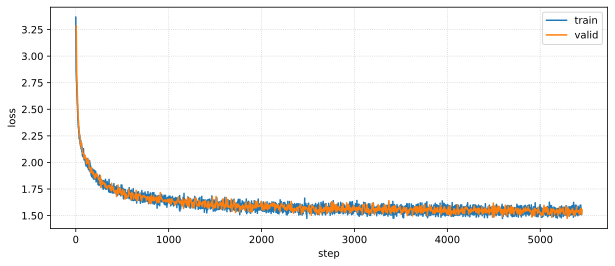

In [117]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="train")
plt.plot(np.array(range(1, len(valid_losses) + 1)) * 5, valid_losses, label="valid")
plt.grid(linestyle="dotted", alpha=0.6)
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

Note we addressed problem of exploding gradients, but not vanishing gradients.

## Decoding

Sampling
- first update state after processing warmup text
- RNN samples one character at a time

In [126]:
def inp(indices: list[int]):
    """Helper to preprocess indices (T,) to (1, T, V) as model input."""
    n = len(vocab)
    return F.one_hot(torch.tensor(indices), n).float().view(1, -1, n).to(DEVICE)
    
def sample_token(out, temp=1.0):
    """Sample next token from output logits with softmax temperature."""
    p = torch.exp(out / temp)   # higher temp => more uniform, i.e. exp ~ 1
    return torch.multinomial(p, num_samples=1).item()

def predict(model, vocab, warmup: str, num_preds: int, temp=1.0):
    """Simulate RNN character generation one at a time."""
    model.to(DEVICE)
    warmup_indices = vocab[list(warmup.lower())]

    # Predict over warmup text. Get final state
    outs, state = model.rnn(inp(warmup_indices))

    # Next token sampling and state update. Start w/ state & token after warmup
    next_token_idx = lambda model, out: sample_token(model.out_layer(out), temp)
    indices = [next_token_idx(model, outs[0, -1, :])]
    for t in range(num_preds - 1):
        out, state = model.rnn(inp([indices[-1]]), state)
        indices.append(next_token_idx(model, out[0, 0, :]))

    return "".join(vocab.to_tokens(warmup_indices + indices))


warmup = "mr williams i understan"
generated_text = []
for i in range(4):
    temp = 0.2 + 0.30 * i
    s = predict(model, vocab, warmup, num_preds=100, temp=temp)
    generated_text.append(f"temp={temp:.1f}   {s}")

print("\n".join(generated_text))

temp=0.2   mr williams i understand the strange in the morlocks in the time traveller the time traveller the should the strange of the
temp=0.5   mr williams i understand and the time traveller the time traveller the time traveller a hand the time traveller i stone the
temp=0.8   mr williams i understand weena and that the linst in mere that end it with a mert in the time traveller the tared for the t
temp=1.1   mr williams i understane of s bur think arvant of ean over which fay of carred in of the time turlors in i stood ruin shart


time traveller mentioned?!

higher temp -> more random, lower temp -> argmax. 

Our only goal is to have it complete the word `understand`. 

One thing to note is that our sampling algorithm only gets the largest probability token which makes it prone to cycles. Also, it would be nice if text generation does some backtracking, i.e. looking at the probability of the text when we add a new character, as well as characters that will follow the added character.

network can generate output with variable-length warmup prompt.

## Appendix: Simple RNN in PyTorch

We can also use the PyTorch RNN module in our language model:

In [36]:
rnn = nn.RNN(d, h, batch_first=True)
x = torch.randn(B, T, d)
outs, state = rnn(x)
assert outs.shape == (B, T, h)
assert state.shape == (1, B, h)
assert torch.abs(outs[:, -1, :] - state).max() < 1e-8

## Appendix: BPTT

- Recall state is updated at each time step, while the parameters of the RNN layer are fixed.
- Thus, we have to track the dependencies across time steps, where the RNN parameters are shared through time steps.
- This is BPTT or BP for sequence models.
- Hopefully, this discussion will bring some precision to the notion of vanishing and exploding gradients. 
- This procedure requires us to expand (or unroll) the computational graph of an RNN one time step at a time. The unrolled RNN is essentially a feedforward neural network with the special property that the same parameters are repeated throughout the unrolled network, appearing at each time step.
- Then we can apply the usual BP through the unrolled net.
- For long sequences, e.g. text sequences containing over a thousand tokens, this poses problems both from a computational (too much memory to compress in a single state vector) and optimization (numerical instability) standpoint. Input from the first step passes through over 1000 matrix products before arriving at the output, and another 1000 matrix products are required to compute the gradient.

want to see
- arrow of time (effect of time steps)
- has a short memory

$a_t = b_t + c_t a_{t - 1}$

$a_t = b_t + c_t (b_{t - 1} + c_{t-1} a_{t-2})$

$a_t = b_t + c_t (b_{t - 1} + c_{t-1} (b_{t - 2} + c_{t-2} a_{t-3}))$

Product propagates inwards:

$a_t = b_t + c_t b_{t - 1} + c_t c_{t-1} b_{t - 2} +  c_t c_{t-1}c_{t-2} a_{t-3}$

$$a_t = b_t + \sum_{i=1}^{t-1} \left( \prod_{j = i + 1}^t c_j\right) b_{i}$$

assuming $a_0 = 0.$

```{figure} ../../../img/nn/04-rnn-backprop.svg
---
width: 500px
align: center
---
RNN cell backpropation. Note that the matrices $\boldsymbol{\mathsf{W}}, \boldsymbol{\mathsf{U}},$ and $\boldsymbol{\mathsf{V}}$ are shared across time steps.
```

Recall:

$$
\begin{aligned}
\boldsymbol{\mathsf{H}}_t &= f(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}} + \boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}} + \boldsymbol{\mathsf{b}}) \\
\boldsymbol{\mathsf{Y}}_t &= \boldsymbol{\mathsf{H}}_t \boldsymbol{\mathsf{V}} + \boldsymbol{\mathsf{c}} \\
\boldsymbol{\mathsf{H}}_{t+1} &= f(\boldsymbol{\mathsf{X}}_{t+1} \boldsymbol{\mathsf{U}} + \boldsymbol{\mathsf{H}}_{t} \boldsymbol{\mathsf{W}} + \boldsymbol{\mathsf{b}}).
\end{aligned}
$$

Assume that there are incoming gradients $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{y}}_t}$ and $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{h}}_{t+1}}$ from the next layer.
We start by calculating the gradient with respect to $\boldsymbol{\mathsf{V}}.$ Here we abstract the product between two tensors on appropriate indices by using the $\text{prod}$ notation. The exact formula can be recovered by index notation. Let $f$ be an activation function. Upper case indicate that a non-parameter tensor's first dimension is the batch dimension. Then, 

$$
\begin{aligned}
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{V}}}}_{(h, q)} &= \sum_{t=1}^T \text{prod}\left(\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}_t}, \frac{\partial \boldsymbol{\mathsf{Y}}_t}{\partial \boldsymbol{\mathsf{V}}}\right) = \sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{H}}_t^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}_t}}_{(h, B) \,\times\, (B, q)} \\
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{c}}}}_{(1, q)}
&= \sum_{t=1}^T \text{prod}\left(\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}_t}, \frac{\partial \boldsymbol{\mathsf{Y}}_t}{\partial \boldsymbol{\mathsf{c}}}\right) = \sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{1}}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}_t}}_{(1, B) \,\times\, (B, q)} 
\end{aligned}
$$

Next, we calculate the gradients flowing to $\boldsymbol{\mathsf{H}}_t$ which will be our gateway to compute gradients of $\boldsymbol{\mathsf{W}}$, $\boldsymbol{\mathsf{U}}$, and $\boldsymbol{\mathsf{b}}$, and finally $\boldsymbol{\mathsf{X}}_t.$ Note that $\boldsymbol{\mathsf{H}}_t$ affects not only $\boldsymbol{\mathsf{Y}}_t$, but also future $\boldsymbol{\mathsf{Y}}_{t^\prime}$ via $\boldsymbol{\mathsf{H}}_{t^\prime}$ for $t^\prime > t.$ But in terms of direct dependence, the nodes that immediately depend on $\boldsymbol{\mathsf{H}}_t$ are $\boldsymbol{\mathsf{Y}}_t$ and $\boldsymbol{\mathsf{H}}_{t+1}.$ Then,

$$
\begin{aligned}
\underbrace{\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}}_{(B, h)}
&= 
\text{prod}\left(
    \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_t}, 
    \frac{\partial\boldsymbol{\mathsf{Y}}_t}{\partial\boldsymbol{\mathsf{H}}_t}
\right) + 
\text{prod}\left(
    \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_{t + 1}}, 
    \frac{\partial\boldsymbol{\mathsf{H}}_{t + 1}}{\partial\boldsymbol{\mathsf{H}}_{t}}
\right) \\
&= 
\underbrace{\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_t}\, \boldsymbol{\mathsf{V}}^\top}_{(B, q)\,\times\,(q, h)} +
\underbrace{
    \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_{t + 1}}
    \text{diag} (f^\prime_{t + 1}) \boldsymbol{\mathsf{W}}^\top
}_{(B, h)\, \times \, (h, h) \, \times \, (h, h)}
\end{aligned}
$$

To make sense of this, recall $\boldsymbol{\mathsf{V}}$ and $\boldsymbol{\mathsf{W}}$ acts on $\boldsymbol{\mathsf{H}}_t$ from the left. Hence, when we take its transpose, multiplying a tensor to the right of $\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}$, results in a summation along the dimension containing information about the state $\boldsymbol{\mathsf{h}}_t.$ 
Similarly, the orientation of the products within the expression are also correct.

Note that the above expression is recursive, we should be able to get a closed form expression from terms in time step $t, t+1, \ldots, T.$ To do this, let us write:

$$
\begin{aligned}
a_t = \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}, \quad
b_t = \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_t}\, \boldsymbol{\mathsf{V}}^\top, \quad
c_t = \text{diag} (f^\prime_{t + 1}) \boldsymbol{\mathsf{W}}^\top
\end{aligned}
$$

with $a_{T+1} = 0$ and $a_T = b_T.$ Thus,

$$
\begin{aligned}
a_t &= b_t + a_{t+1} c_t \\
&= b_t + (b_{t + 1} + a_{t + 2} c_{t + 1}) c_t \\ 
&= b_t + (b_{t + 1} + (b_{t + 2} + a_{t + 3} c_{t + 2}) c_{t + 1}) c_t \\
&= b_t + b_{t + 1} c_t + b_{t + 2}c_{t + 1}c_t + a_{t + 3} c_{t + 2}c_{t + 1}c_t \\
&\vdots \\
&= b_t + \sum_{t^\prime = t + 1}^T b_{t^\prime} \prod_{j=t}^{t^\prime - 1} c_j.
\end{aligned}
$$

Thus, 

$$
\boxed{
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t} = 
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_t}\, \boldsymbol{\mathsf{V}}^\top
+ 
\sum_{t^\prime = t + 1}^T
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_{t^\prime}}\, \boldsymbol{\mathsf{V}}^\top
\prod_{j=t}^{t^\prime - 1} 
\text{diag} (f^\prime_{j + 1}) \boldsymbol{\mathsf{W}}^\top.
}
$$ (state_vec_grad)

In the simplified linear case, 

$$
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t} = 
\sum_{t^\prime = t}^T
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_{t^\prime}}\, \boldsymbol{\mathsf{V}}^\top
\left(\boldsymbol{\mathsf{W}}^\top\right)^{t^\prime - t}.
$$

This formula is similar to that for gradient flow across the layers of a deep MLP network, but here the depth is along sequence length. The changes due to the current time step is only due to its effect on future time steps, not on the past, so we have a notion of causality in RNNs.

Finally, let's calculate the rest of the parameter gradients. Let $\boldsymbol{\mathsf{Z}}_t = \boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}} + \boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}} + \boldsymbol{\mathsf{b}}$. Then,

$$
\begin{aligned}
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{U}}}}_{(d, h)} &= \sum_{t=1}^T \text{prod}\left(
    \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}, 
    \frac{\partial \boldsymbol{\mathsf{H}}_t}{\partial \boldsymbol{\mathsf{Z}}_t},
    \frac{\partial \boldsymbol{\mathsf{Z}}_t}{\partial \boldsymbol{\mathsf{U}}}
\right) 
= 
\sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{X}}_{t}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t} \text{diag}(f^\prime_t)}_{(d, B) \,\times\, (B, h) \, \times\, (h, h)}
\\
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{W}}}}_{(h, h)} &= \sum_{t=1}^T \text{prod}\left(
    \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}, 
    \frac{\partial \boldsymbol{\mathsf{H}}_t}{\partial \boldsymbol{\mathsf{Z}}_t},
    \frac{\partial \boldsymbol{\mathsf{Z}}_t}{\partial \boldsymbol{\mathsf{W}}}
\right) 
= 
\sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{H}}_{t-1}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t} \text{diag}(f^\prime_t)}_{(h, B) \,\times\, (B, h) \, \times\, (h, h)} \\
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{b}}}}_{(1, h)}
&= 
\sum_{t=1}^T \text{prod}\left(
    \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}, 
    \frac{\partial \boldsymbol{\mathsf{H}}_t}{\partial \boldsymbol{\mathsf{Z}}_t},
    \frac{\partial \boldsymbol{\mathsf{Z}}_t}{\partial \boldsymbol{\mathsf{b}}}
\right) 
= \sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{1}}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}  \text{diag}(f^\prime_t)}_{(1, B) \,\times\, (B, h) \, \times \, (h, h)}.
\end{aligned}
$$

The gradient to inputs may be also relevant (e.g. deep RNNs):

$$
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{X}}_t}}_{(B, d)}
=
\text{prod}\left(
    \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}, 
    \frac{\partial \boldsymbol{\mathsf{H}}_t}{\partial \boldsymbol{\mathsf{Z}}_t},
    \frac{\partial \boldsymbol{\mathsf{Z}}_t}{\partial \boldsymbol{\mathsf{X}}_t}
\right) 
= \underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}  \text{diag}(f^\prime_t)\, \boldsymbol{\mathsf{U}}^\top}_{(B, h) \, \times \, (h, h) \, \times \, (h, d)}
$$

Hence, the key quantity that affects the numerical stability is $\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}$ {eq}`state_vec_grad`. 

## Appendix: Vanishing and exploding gradients

From the BP equations, the key quantity that affects the numerical stability is $\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}$ {eq}`state_vec_grad`. Suppose $\boldsymbol{\mathsf{W}}$ has a diagonalization $\boldsymbol{\mathsf{W}} = \boldsymbol{\mathsf{Q}}\boldsymbol{\Lambda} \boldsymbol{\mathsf{Q}}^{-1}$ where $\boldsymbol{\Lambda} = \text{diag}(\lambda_1, \ldots, \lambda_n)$ with $|\lambda_1| > \ldots > |\lambda_n|$, then 

$$
\boldsymbol{\mathsf{W}}^k = \boldsymbol{\mathsf{Q}}\boldsymbol{\Lambda}^k \boldsymbol{\mathsf{Q}}^{-1}.
$$

In this case, the principal eigenvalue will dominate. If $|\lambda_1| > 1,$ then this product diverges while if $|\lambda_1| < 1,$ the product quickly vanishes to zero. To see this better, let $\boldsymbol{\mathsf{x}}$ be any vector in $\mathbb{R}^h.$ Then, $\boldsymbol{\mathsf{x}} = \boldsymbol{\mathsf{Q}}\boldsymbol{\mathsf{x}}^\prime.$ Thus, 

$$
\begin{aligned}
\boldsymbol{\mathsf{W}}^k \boldsymbol{\mathsf{x}} &= \boldsymbol{\mathsf{Q}} \boldsymbol{\Lambda}^k \boldsymbol{\mathsf{x}}^\prime \\
&= \lambda_1^k \sum_{i=1}^h {\mathsf{x}}^\prime_i \left(\frac{\lambda_i}{\lambda_1}\right)^k \boldsymbol{\mathsf{q}}_i \to \lambda_1^k  {\mathsf{x}}^\prime_1 \boldsymbol{\mathsf{q}}_1
\end{aligned}
$$

as $k \to \infty.$ Passing in each standard basis element as $\boldsymbol{\mathsf{x}}$, we recover the columns of $\boldsymbol{\mathsf{W}}^k$ as a vector along the principle eigenvector with norm proportional to $|\lambda_1|^k$. This is verified in the code below:

In [149]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(10)

norms = {
    0.9: [],
    1.1: []
}

for c in norms.keys():
    A = np.random.normal(size=(10, 10))
    lambda_1 = np.linalg.norm(np.linalg.eig(A).eigenvalues[0])
    A = A / lambda_1 * c
    x = np.random.randn(10).reshape(-1, 1)
    norms[c].append(np.linalg.norm(x))

    N = 100
    for i in range(N):
        x = A @ x
        norms[c].append(np.linalg.norm(x))

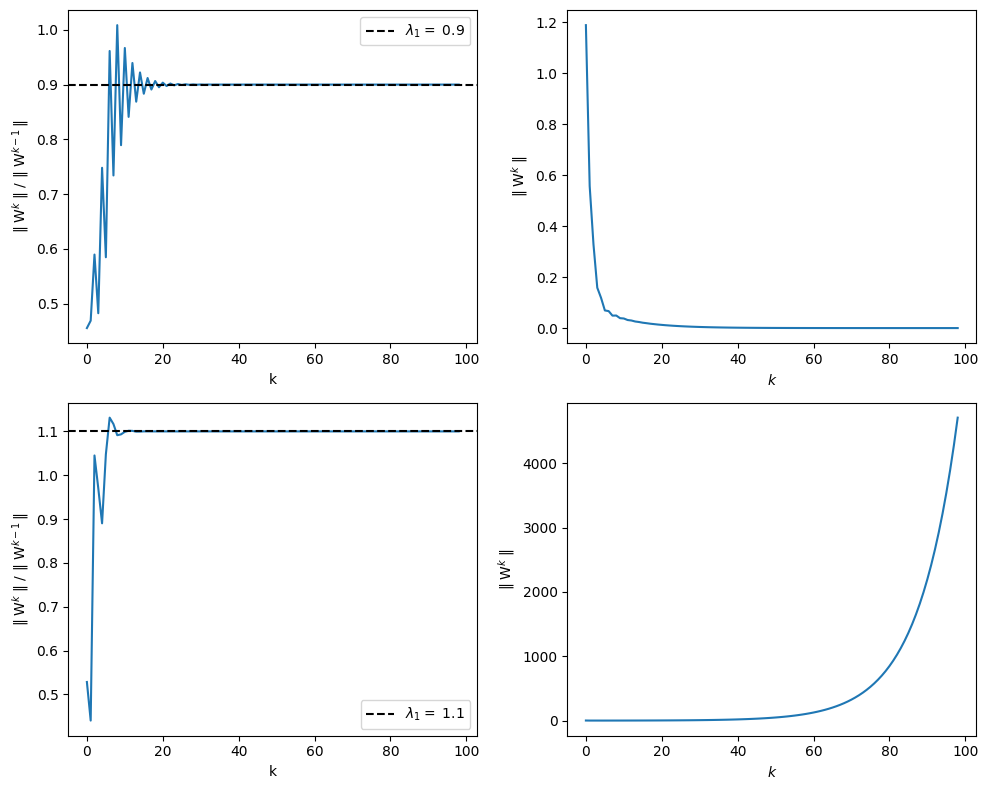

In [150]:
# Plotting
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for j, c in enumerate(norms.keys()):
    ax[j, 0].plot([norms[c][k] / norms[c][k-1] for k in range(1, N)])
    ax[j, 0].axhline(c, color="k", linestyle="dashed", label=r"$\lambda_1 =$" + f" {c}")
    ax[j, 0].set_ylabel(r"$\|\; \boldsymbol{\mathsf{W}}^k \;\| \; / \;\, \|\; \boldsymbol{\mathsf{W}}^{k-1} \,\|$")
    ax[j, 0].set_xlabel("k")
    ax[j, 0].legend()

    # Plotting
    ax[j, 1].plot([norms[c][k] for k in range(1, N)])
    ax[j, 1].set_ylabel(r"$\|\; \boldsymbol{\mathsf{W}}^k \;\|$")
    ax[j, 1].set_xlabel(r"$k$")

fig.tight_layout();